# Text Analytics Final Project 

#### Praneet Solanki | Emmanuel Awa

MIND data are stored in the West/East US data center, so this notebook will run more efficiently on the Azure compute located in West/East US.

## Imports and environment

In [173]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re


required = {'scikit-learn', 'numpy', 
            'pandas', 'matplotlib',
            'transformers'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)


In [1]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd

import torch
import torch.nn as nn

# your imports may be different
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from spacy.lang.en import English


# from transformers import DistilBertModel, DistilBertTokenizer



In [3]:
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()
en = English()


In [4]:
# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
# temp_dir = os.path.join(tempfile.gettempdir(), 'mind')

data_folder = "mind_dataset"
temp_dir = data_folder

os.makedirs(temp_dir, exist_ok=True)


# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

## Functions

In [5]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

## Download and extract the files

In [6]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(training_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_train.zip


['entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_train.zip',
 'relation_embedding.vec',
 'news.tsv',
 'behaviors.tsv',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip']

## Read the files with pandas

In [7]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

In [8]:
news.head()

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [9]:
news.shape

(51282, 8)

In [10]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [11]:
news.groupby('category').describe()

id                     subcategory         \
               count unique     top freq       count unique   
category                                                      
autos           1639   1639  N33781    1        1639     24   
entertainment    587    587  N19288    1         587     15   
finance         3107   3107  N55675    1        3107     32   
foodanddrink    2551   2551  N34837    1        2551     16   
health          1885   1885  N36061    1        1885     20   
kids              17     17  N47156    1          17      5   
lifestyle       2479   2479  N33013    1        2479     47   
middleeast         2      2  N14979    1           2      1   
movies           606    606  N16545    1         606      7   
music            769    769  N34937    1         769     11   
news           15774  15774  N63373    1       15774     33   
northamerica       1      1  N57229    1           1      1   
sports         14510  14510    N160    1       14510     31   
travel          2350   2350  N36215    1        2350     14   
tv               889    889  N61088    1         889     10   
video           2068   2068  N35908    1        2068     14   
weather         2048   2048  N54425    1        2048      2   

                                             title         ...  \
                                  top  freq  count unique  ...   
category                                                   ...   
autos                       autosnews   837   1639   1630  ...   
entertainment               celebrity   145    587    581  ...   
finance                   financenews   697   3107   3083  ...   
foodanddrink               newstrends  1175   2551   2531  ...   
health                        medical   479   1885   1876  ...   
kids                    people-places     5     17     17  ...   
lifestyle               lifestylebuzz   894   2479   2462  ...   
middleeast     middleeast-top-stories     2      2      2  ...   
movies                      movienews   231    606    603  ...   
music                       musicnews   414    769    763  ...   
news                           newsus  6564  15774  15570  ...   
northamerica       northamerica-video     1      1      1  ...   
sports                   football_nfl  5420  14510  14133  ...   
travel                  travelarticle  1042   2350   2333  ...   
tv                             tvnews   377    889    886  ...   
video                            news  1168   2068   2054  ...   
weather             weathertopstories  2047   2048   2007  ...   

                                                         url       \
                                                         top freq   
category                                                            
autos          https://assets.msn.com/labs/mind/BBWCOF2.html    1   
entertainment  https://assets.msn.com/labs/mind/BBWBBR7.html    1   
finance        https://assets.msn.com/labs/mind/BBWEIuL.html    1   
foodanddrink   https://assets.msn.com/labs/mind/AAJnmnL.html    1   
health         https://assets.msn.com/labs/mind/AAIPtXW.html    1   
kids           https://assets.msn.com/labs/mind/BBWqvqj.html    1   
lifestyle      https://assets.msn.com/labs/mind/AAJTogv.html    1   
middleeast     https://assets.msn.com/labs/mind/AAJBApe.html    1   
movies         https://assets.msn.com/labs/mind/AAJNq0d.html    1   
music          https://assets.msn.com/labs/mind/AAJufAA.html    1   
news           https://assets.msn.com/labs/mind/AAJ1Qhi.html    1   
northamerica   https://assets.msn.com/labs/mind/BBWFdBy.html    1   
sports         https://assets.msn.com/labs/mind/AAJ4nHP.html    1   
travel         https://assets.msn.com/labs/mind/AAJH2dN.html    1   
tv             https://assets.msn.com/labs/mind/BBWtjpO.html    1   
video          https://assets.msn.com/labs/mind/AAIF6RA.html    1   
weather        https://assets.msn.com/labs/mind/AAJQ1tY.html    1   

              title_entities         \
                

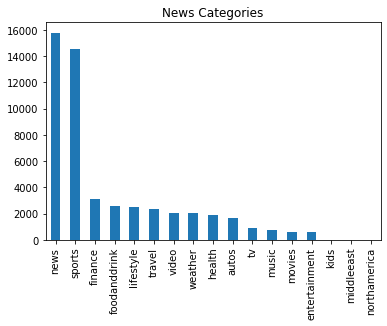

In [12]:
# Distribution of the categories
news.category.value_counts().plot.bar(title="News Categories");

## From the data, we need only few columns

In [13]:
df = news[["category","title","abstract"]]

In [14]:
df.isnull()

,category,title,abstract
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
51277,False,False,False
51278,False,False,True
51279,False,False,False
51280,False,False,False


In [15]:
df.dropna(inplace=True)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
df.shape

(48616, 3)

In [17]:
df["text"] = df["title"].astype(str) + df["abstract"].astype(str)
df.drop(columns=['title', 'abstract'], inplace=True)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
df.head()

,category,text
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
1,health,50 Worst Habits For Belly FatThese seemingly h...
2,news,The Cost of Trump's Aid Freeze in the Trenches...
3,health,I Was An NBA Wife. Here's How It Affected My M...
4,health,"How to Get Rid of Skin Tags, According to a De..."


In [19]:
category_list = list(news.category.unique())
print(len(category_list))
category_list

17


['lifestyle',
 'health',
 'news',
 'sports',
 'weather',
 'entertainment',
 'autos',
 'travel',
 'foodanddrink',
 'tv',
 'finance',
 'movies',
 'video',
 'music',
 'kids',
 'middleeast',
 'northamerica']

In [20]:
chosen = ['sports', 'finance', 'foodanddrink', 'health', 'travel','weather', 'movies', 'music']

In [21]:
df = df[df.category.isin(chosen)]
df.reset_index(drop=True, inplace=True)
display(df.head(10))
display(df.shape)

,category,text
0,health,50 Worst Habits For Belly FatThese seemingly h...
1,health,I Was An NBA Wife. Here's How It Affected My M...
2,health,"How to Get Rid of Skin Tags, According to a De..."
3,sports,Should NFL be able to fine players for critici...
4,weather,It's been Orlando's hottest October ever so fa...
5,health,"50 Foods You Should Never Eat, According to He..."
6,health,25 Biggest Grocery Store Mistakes Making You G...
7,health,Instagram Filters with Plastic Surgery-Inspire...
8,health,"Michigan apple recall: Nearly 2,300 crates cou..."
9,travel,Newark Liberty Airport's Terminal One a $2.7 b...


(26084, 2)

## Tokenizer

In [22]:
# Defining a tokenizer 
# Pipeline to remove stop words, urls, punct and lammatize words

def better_tokenizer(doc, model=en):
  return [x.lemma_.lower() for x in en(doc) if (x.is_alpha)&
          (not x.like_url)&(not x.is_punct)&(not x.is_stop)]

In [23]:
# Creating tokenized representation 
all_data = [better_tokenizer(str(d)) for d in df['text']]

In [24]:
all_data[0]

['worst',
 'habits',
 'belly',
 'fatthese',
 'seemingly',
 'harmless',
 'habits',
 'holding',
 'keeping',
 'shedding',
 'unwanted',
 'belly',
 'fat',
 'good']

In [25]:
# this formulation works if you have previously tokenized
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2) # min_df=0.001, max_df=0.9)
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2)#min_df=0.001, max_df=0.9)

In [26]:
# **important** just fit on trained: prevents information from test in training 
cv_vecs = cv.fit_transform(all_data).toarray()
tfidf_vecs = tfidf.fit_transform(all_data).toarray()


# get out the vocab (same for tfidf)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

Size of vocab: 23012


In [27]:
display(cv_vecs.shape)
display(tfidf_vecs.shape)

(26084, 23012)

(26084, 23012)

### Top words for each news category articles (Counts and TF-IDF)

In [28]:
# get top x words
top_words = 10


# Getting the correct index for rows in the train dataset. The original index are kept intact and not reset.

categories_rows_indx = []

for category in chosen:
    categories_rows_indx.append((category, df.index[df['category'] == category].tolist()))


In [29]:
# fcategory_list[:4]
len(categories_rows_indx)

8

In [31]:
for vectorizer, vecs  in [(cv, cv_vecs), (tfidf, tfidf_vecs)]:
    print(f"Top {top_words} words using {vectorizer.__class__.__name__}")
    for category, indx in categories_rows_indx:    
        # sum counts
        s_sum = vecs[indx].sum(axis=0)
        # sort arguments
        s_sorted = np.argsort(s_sum)
        # print top words
        print(f"{category} category")
        print([vectorizer.get_feature_names()[x] for x in s_sorted[-top_words:]])
#         print("\n")
    print("\n")


Top 10 words using CountVectorizer
sports category
['nfl', 'night', 'state', 'new', 'win', 'football', 'team', 'week', 'season', 'game']
finance category
['money', 'trade', 'state', 'city', 'said', 'million', 'home', 'company', 'year', 'new']
foodanddrink category
['restaurants', 'holiday', 'taste', 'home', 'recipes', 'restaurant', 'thanksgiving', 'best', 'food', 'new']
health category
['flu', 'says', 'help', 'study', 'said', 'people', 'weight', 'cancer', 'new', 'health']
travel category
['fire', 'county', 'flight', 'day', 'world', 'airport', 'best', 'said', 'city', 'new']
weather category
['new', 'temperatures', 'area', 'morning', 'storm', 'cold', 'said', 'snow', 'fire', 'weather']
movies category
['films', 'hollywood', 'actor', 'million', 'movies', 'star', 'new', 'trailer', 'movie', 'film']
music category
['cma', 'john', 'year', 'band', 'singer', 'awards', 'country', 'tour', 'new', 'music']


Top 10 words using TfidfVectorizer
sports category
['night', 'patriots', 'state', 'nfl', 'wi

In [32]:
n_components=10

nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

# tfidf for nmf
nmf_vecs = nmf.fit_transform(tfidf_vecs)
# count for lda
lda_vecs = lda.fit_transform(cv_vecs)

In [33]:
# topic model performance
print('NMF Reconstruction err:', nmf.reconstruction_err_)
print('LDA ELBO:', lda.bound_)

NMF Reconstruction err: 159.37150447307081
LDA ELBO: 5241.807319154335


In [34]:
# Topic model top 10 words
def display_components(model, word_features, top_display=8):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))

In [35]:
print('Displaying top 10 words in each topic using NMF(tfidf): ')
display_components(nmf, tfidf.get_feature_names())

print('\n')

print('Displaying top 10 words in each topic using LDA(CountVectorizer): ')
display_components(lda, cv.get_feature_names())

Displaying top 10 words in each topic using NMF(tfidf): 
Topic 0:
game season win night sunday team chiefs injury
Topic 1:
weather today forecast snow cold temperatures winter record
Topic 2:
world series astros nationals game washington houston yankees
Topic 3:
football state college michigan school high playoff penn
Topic 4:
week nfl steelers rankings power teams highlights ravens
Topic 5:
patriots new england brady tom ravens belichick jets
Topic 6:
best thanksgiving recipes food holiday home turkey taste
Topic 7:
fire said county day new people california area
Topic 8:
trailer day little knives bombshelltrailer dark christmastrailer queen
Topic 9:
apartments photos price rent real estate dollar budget


Displaying top 10 words in each topic using LDA(CountVectorizer): 
Topic 0:
chiefs state city michigan mahomes patrick kansas broncos
Topic 1:
new food home restaurant best city thanksgiving holiday
Topic 2:
day veterans panthers bengals sunday year quarterback ravens
Topic 3:
footb

##  Fitting SVM models for TFIDF, CV, NMF, LDA and Glove vectors

### Split dataset in train, val, test

In [36]:

# # notebook parameters
# DATA_FOLDER = TemporaryDirectory().name
# CACHE_DIR = TemporaryDirectory().name
NUM_EPOCHS = 1
BATCH_SIZE = 32
NUM_GPUS = torch.cuda.device_count()
MAX_LEN = 100
TRAIN_DATA_FRACTION = 0.
TEST_DATA_FRACTION = 0.5
TRAIN_SIZE = 0.75
LABEL_COL = "category"
TEXT_COL = "text"
MODEL_NAMES = ["distilbert-base-uncased", "roberta-base", "xlnet-base-cased"]

In [163]:
df_train, df_test = train_test_split(df, train_size = TRAIN_SIZE, random_state=0)

In [ ]:
# # sample
# df_train = df_train.sample(frac=TRAIN_DATA_FRACTION).reset_index(drop=True)
# df_test = df_test.sample(frac=TEST_DATA_FRACTION).reset_index(drop=True)

In [164]:
#data prep for SVM Training
X_train_text = df_train['text']
y_train = df_train['category']
X_test_text = df_test['text']
y_test = df_test['category']

In [165]:
# Initialize models/vectorizers to use

n_components=10

svc = LinearSVC()
tfidf = TfidfVectorizer(tokenizer=better_tokenizer, min_df=2)
cv = CountVectorizer(tokenizer=better_tokenizer, min_df=2)
nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

In [182]:
# TFIDF featureset
tfidf_train = tfidf.fit_transform(X_train_text)
tfidf_test = tfidf.transform(X_test_text)

# CV featureset
cv_train = cv.fit_transform(X_train_text)
cv_test = cv.transform(X_test_text)


# NMF featureset
nmf_train = nmf.fit_transform(tfidf_train)
nmf_test = nmf.transform(tfidf_test)


# Glove featureset
glove_train = np.concatenate([nlp(doc).vector.reshape(1, -1) for doc in X_train_text])
glove_test = np.concatenate([nlp(doc).vector.reshape(1, -1) for doc in X_test_text])

### Fit SVC with all the vectors

In [188]:
# fit/predict on full dataset
svc = LinearSVC()
for pair in [(tfidf_train, tfidf_test, "tfidf"),
             (cv_train, cv_test, "cv"),
            (nmf_train, nmf_test, "nmf"),
            (glove_train, glove_test, "glove"),
#             (bert_train, bert_val)
            ]:
    svc.fit(pair[0], y_train)
    preds_test = svc.predict(pair[1])
    preds_train = svc.predict(pair[0])
    print(f"{pair[2]} Train acc : ",accuracy_score(y_train, preds_train))
    print(f"{pair[2]} Test acc : ",accuracy_score(y_test, preds_test))
    print("\n")

tfidf Train acc :  0.9953483617032153
tfidf Test acc :  0.8865204723201963


cv Train acc :  0.9998466492869191
cv Test acc :  0.8589173439656494


nmf Train acc :  0.6161120482543577
nmf Test acc :  0.6218371415427082


glove Train acc :  0.90788733834279
glove Test acc :  0.8925011501303481




In [175]:
# # basic pretrained model (case-insensitive)
# MODEL_NAME = 'distilbert-base-uncased'
# # Load pre-trained model
# model = DistilBertModel.from_pretrained(MODEL_NAME)
# # Load pre-trained model tokenizer (vocabulary)
# tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [176]:
# st = 0
# # batch-wise, otherwise tends to take a long time
# batches = list(range(100, len(df), 100))+[len(df)]
# doc_rep_collector = []
# for b in batches:
#     tokens = tokenizer.batch_encode_plus(df['text'][st:b],
#       pad_to_max_length=True, return_tensors="pt")
#     st = b
#     outputs = model(**tokens)
#     # taking the representation of the 'CLS' token (doc-level embedding)
#     doc_rep_collector.append(outputs[0][:,0].detach().numpy())
#     break
# doc_rep_collector = np.concatenate(doc_rep_collector)

In [177]:
# import pickle
# pickle.dump(doc_rep_collector,
#             open('bert_vectors.pkl', 'wb'))

In [179]:
# # BERT: use the vectors from the pickle file
# bert_vectors = pickle.load(open('bert_vectors.pkl', 'rb'))
# bert_train = bert_vectors[df_train.index]
# #bert_val = bert_vectors[val.index]
# bert_test = bert_vectors[df_test.index]